Fitted beta: 0.5000, Fitted m: 0.9624
Fitted beta: 0.5421, Fitted m: 0.9699


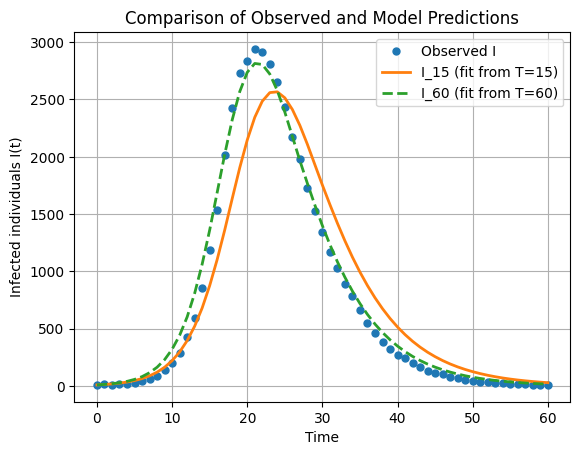

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
file_path = r'C:\Users\dell\.jupyter\obs_I.csv'

# The csv file had both the I and t column mixed in one colon, this is for making a cleand data frame
data = []
with open(file_path, 'r') as f:
    lines = f.readlines()[1:]  # skip header line 't,I'
    for line in lines:
        line = line.strip()
        if line:
            t_str, I_str = line.split(',', 1)
            data.append([
                float(t_str.replace(',', '.')),
                float(I_str.replace(',', '.'))
            ])

df = pd.DataFrame(data, columns=['t', 'I'])

# in the csv file what should have been for example 0|10 was written instead as 0,1(excel igonerd the 0)
I_obs = df['I'].to_numpy(dtype=int) 
time = df['t'].to_numpy(dtype=int)
changed = True
while changed:
    changed = False
    ratios_forward = I_obs[:-1] / I_obs[1:]
    idx_f = np.where(ratios_forward < 0.1)[0]
    if len(idx_f) > 0:
        I_obs[idx_f] *= 10
        changed = True
    ratios_backward = I_obs[1:] / I_obs[:-1]
    idx_b = np.where(ratios_backward < 0.1)[0] + 1
    if len(idx_b) > 0:
        I_obs[idx_b] *= 10
        changed = True
"""********************************************Values**********************************"""
N = 10000
mu = 0.2
R0 = 0
I0 = 10
S0 = N - R0 - I0 
#model
def SIR_mod(t, y, beta, m):
    S, I, R = y
    dSdt = mu * (m - 1) * I - (beta / N) * I * S
    dIdt = -mu * (2 * m - 1) * I + (beta / N) * I * S
    dRdt = mu * m * I
    return [dSdt, dIdt, dRdt]
"""*****************************************T_obs=15***************************************"""
T_obs_15 = 15
#Function for the approximated I(t)
def I_model_15(t, beta, m, I0, mu):
    t = np.asarray(t)
    return I0 * np.exp((beta - mu * (2 * m - 1)) * t)
    
#I will use the least squre method
def Least_squared(params, I_obs, t):
    beta, m = params
    I_pred = I_model_15(t, beta, m, I0, mu)
    return np.sum((I_pred - I_obs)**2) 

#minimising the Least_squared function
t_data_15 = time[:T_obs_15]
I_data_15 = I_obs[:T_obs_15]
initial_guess = [0.5, 0.5]  # [beta, m]
bounds = [(1e-6, None), (0, None)]  # beta>0 and m>=0
result = minimize(Least_squared, initial_guess, args=(I_data_15, t_data_15), bounds=bounds)
beta_15, m_15 = result.x
print(f"Fitted beta: {beta_15:.4f}, Fitted m: {m_15:.4f}") 

# Solve the system with the fitted parameters
t_span = (0, 60)
t_eval = np.arange(0, 61, 1) 
sol = solve_ivp(lambda t, y: SIR_mod(t, y, beta_15, m_15),
                t_span, [S0, I0, R0], t_eval=t_eval)

I_15 = sol.y[1]

"""*****************************************T_obs=60***************************************"""
T_obs = 60
J0 = 0 
t_data_60 = time[:T_obs]
I_data_60 = I_obs[:T_obs]
"""dIdt = I*((beta/N)(N-I-mu*m*int_{0}^tI(s)ds)- mu*(2*m-1)) and dJdt = I"""
def dIdt_integral_form(t, y, beta, m, mu, N):
    I, J = y  # J(t) = int_0^t I(s) ds
    dIdt = I * ((beta / N) * (N - I - mu * m * J) - mu * (2 * m - 1))
    dJdt = I
    return [dIdt, dJdt] 
#Solving
def I_model_integral(t, beta, m, I0, mu, N):
    sol = solve_ivp(lambda t, y: dIdt_integral_form(t, y, beta, m, mu, N),
                    (t[0], t[-1]), [I0, 0], t_eval=t)
    return sol.y[0]  
#Least square method
def Least_squared_integral(params, I_obs, t):
    beta, m = params
    I_pred = I_model_integral(t, beta, m, I0, mu, N)
    return np.sum((I_pred - I_obs)**2)

result = minimize(Least_squared_integral, initial_guess,
                  args=(I_data_60, t_data_60),
                  bounds=bounds)
beta_fit, m_fit = result.x
print(f"Fitted beta: {beta_fit:.4f}, Fitted m: {m_fit:.4f}")
"""**********************************Ploting*********************************"""
I_60 = I_model_integral(t_eval, beta_fit, m_fit, I0, mu, N)

plt.plot(time, I_obs, 'o', label='Observed I', markersize=5)

plt.plot(t_eval, I_15, '-', label='I_15 (fit from T=15)', linewidth=2)

plt.plot(t_eval, I_60, '--', label='I_60 (fit from T=60)', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Infected individuals I(t)')
plt.title('Comparison of Observed and Model Predictions')
plt.legend()
plt.grid(True)
plt.show()
